```
curve_project/
│
├── data/
│   ├── isolated.csv
│   ├── frag0.csv
│   ├── frag1.csv
│   ├── occlusion1.csv
│   ├── occlusion2.csv
│
├── models/
│   ├── shape_recognition_model.pth
│   ├── symmetry_detection_model.pth
│   └── curve_completion_model.pth
│
├── scripts/
│   ├── main.py
│   ├── curve_regularization.py
│   ├── symmetry_detection.py
│   ├── curve_completion.py
│   ├── train_model.py
│   └── utils.py
│
└── output/
    ├── regularized_shapes/
    ├── detected_symmetries/
    └── completed_curves/
```

In [1]:
# dependencies
%pip install numpy matplotlib scipy torch torchvision pillow scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
# mouting the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# utils.py

import numpy as np
import matplotlib.pyplot as plt

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, title='Plot'):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.title(title)
    plt.show()



In [7]:
# curve_regularization.py

import numpy as np
from scipy.spatial import ConvexHull

def identify_shapes(path_XYs):
    regular_shapes = []
    for shape in path_XYs:
        shape = np.array(shape)  # Convert shape to NumPy array for operations
        if is_circle(shape):
            regular_shapes.append('Circle')
        elif is_ellipse(shape):
            regular_shapes.append('Ellipse')
        elif is_rectangle(shape):
            regular_shapes.append('Rectangle')
        elif is_polygon(shape):
            regular_shapes.append('Polygon')
        elif is_star(shape):
            regular_shapes.append('Star')
        else:
            regular_shapes.append('Unknown')
    return regular_shapes

def is_circle(XYs):
    center = np.mean(XYs, axis=0)
    radii = np.linalg.norm(XYs - center, axis=1)
    return np.std(radii) < 0.05 * np.mean(radii)

def is_ellipse(XYs):
    cov = np.cov(XYs.T)
    eigvals, _ = np.linalg.eigh(cov)
    return eigvals[0] / eigvals[1] > 0.5

def is_rectangle(XYs):
    hull = ConvexHull(XYs)
    return len(hull.vertices) == 4

def is_polygon(XYs):
    hull = ConvexHull(XYs)
    return len(hull.vertices) > 4

def is_star(XYs):
    return len(XYs) > 10 and np.mean(np.linalg.norm(XYs - np.mean(XYs, axis=0), axis=1)) > 0.1 * np.max(np.linalg.norm(XYs - np.mean(XYs, axis=0), axis=1))

# Sample usage (adjust the paths and function calls as needed)
# path_XYs = read_csv('/content/drive/MyDrive/curve_project/data/isolated.csv')
# shapes = identify_shapes(path_XYs)
# print(shapes)
# plot(path_XYs, title='Regularized Shapes')



In [8]:
# symmetry_detection.py

import numpy as np

def detect_symmetry(path_XYs):
    symmetries = []
    for shape in path_XYs:
        if has_reflection_symmetry(shape):
            symmetries.append('Reflection Symmetry')
        elif has_rotational_symmetry(shape):
            symmetries.append('Rotational Symmetry')
        else:
            symmetries.append('No Symmetry')
    return symmetries

def has_reflection_symmetry(XYs):
    for angle in np.linspace(0, np.pi, 180):
        rotated_XYs = rotate_points(XYs, angle)
        if np.allclose(rotated_XYs, np.flip(rotated_XYs, axis=0)):
            return True
    return False

def has_rotational_symmetry(XYs):
    center = np.mean(XYs, axis=0)
    for angle in np.linspace(0, 2 * np.pi, 360):
        rotated_XYs = rotate_points(XYs - center, angle) + center
        if np.allclose(XYs, rotated_XYs):
            return True
    return False

def rotate_points(XYs, angle):
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return XYs.dot(rotation_matrix)

# if __name__ == "__main__":
#     path_XYs = read_csv('/content/drive/MyDrive/curve_project/data/frag0.csv')
#     symmetries = detect_symmetry(path_XYs)
#     print(symmetries)
#     plot(path_XYs, title='Symmetry Detection')




In [9]:
# curve_completion.py

import numpy as np
from scipy.interpolate import splprep, splev

def complete_curve(path_XYs):
    completed_paths = []
    for shape in path_XYs:
        completed_shape = interpolate_missing_parts(shape)
        completed_paths.append(completed_shape)
    return completed_paths

def interpolate_missing_parts(XYs):
    tck, u = splprep([XYs[:, 0], XYs[:, 1]], s=0)
    u_new = np.linspace(u.min(), u.max(), len(XYs))
    x_new, y_new = splev(u_new, tck, der=0)
    return np.vstack((x_new, y_new)).T

# if __name__ == "__main__":
#     path_XYs = read_csv('/content/drive/MyDrive/curve_project/data/occlusion1.csv')
#     completed_paths = complete_curve(path_XYs)
#     plot(completed_paths, title='Completed Curves')




In [19]:
# Shape Generation

import numpy as np
import csv

def generate_polyline(shape_type, num_points=50):
    if shape_type == 'circle':
        theta = np.linspace(0, 2 * np.pi, num_points)
        r = 10  # fixed radius
        x = r * np.cos(theta)
        y = r * np.sin(theta)
    elif shape_type == 'ellipse':
        theta = np.linspace(0, 2 * np.pi, num_points)
        a, b = 10, 5  # semi-major and semi-minor axes
        x = a * np.cos(theta)
        y = b * np.sin(theta)
    elif shape_type == 'rectangle':
        x = np.array([0, 10, 10, 0, 0])
        y = np.array([0, 0, 5, 5, 0])
    elif shape_type == 'polygon':
        n_sides = 6  # hexagon
        theta = np.linspace(0, 2 * np.pi, n_sides + 1)
        x = 10 * np.cos(theta)
        y = 10 * np.sin(theta)
    elif shape_type == 'star':
        angles = np.linspace(0, 2 * np.pi, num_points)
        radii = np.where(np.arange(num_points) % 2 == 0, 10, 5)
        x = radii * np.cos(angles)
        y = radii * np.sin(angles)
    else:
        raise ValueError("Unsupported shape_type. Use 'circle', 'ellipse', 'rectangle', 'polygon', or 'star'.")

    return np.stack([x, y], axis=-1)

def save_polyline_to_csv(polyline, file_name):
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "X", "Y"])  # Header
        for i, (x, y) in enumerate(polyline):
            writer.writerow([1, x, y])  # ID is kept constant for simplicity

# Generate and save polylines for various shapes
shapes = ['circle', 'ellipse', 'rectangle', 'polygon', 'star']
for shape in shapes:
    polyline = generate_polyline(shape)
    save_polyline_to_csv(polyline, f'/content/drive/MyDrive/curve_project/data/{shape}.csv')


In [20]:
# train_model.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import copy

class PolylineDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

def create_data_from_polylines(csv_files, img_size=(64, 64)):
    data = []
    labels = []
    label_mapping = {'circle': 0, 'ellipse': 1, 'rectangle': 2, 'polygon': 3, 'star': 4}

    for csv_file in csv_files:
        path_XYs = read_csv(csv_file)
        for shape in path_XYs:
            fig, ax = plt.subplots(figsize=(img_size[0] / 100, img_size[1] / 100), dpi=100)
            ax.set_xlim(0, img_size[0])
            ax.set_ylim(0, img_size[1])

            for XY in shape:
                if XY.shape[1] < 2:
                    continue
                ax.plot(XY[:, 0], XY[:, 1], 'k', linewidth=2)

            ax.axis('off')
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(img_size[1], img_size[0], 3)
            data.append(Image.fromarray(image))
            shape_name = os.path.basename(csv_file).split('.')[0]
            labels.append(label_mapping[shape_name])
            plt.close(fig)

    return data, labels

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10, patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')

    csv_files = [
        '/content/drive/MyDrive/curve_project/data/circle.csv',
        '/content/drive/MyDrive/curve_project/data/ellipse.csv',
        '/content/drive/MyDrive/curve_project/data/rectangle.csv',
        '/content/drive/MyDrive/curve_project/data/polygon.csv',
        '/content/drive/MyDrive/curve_project/data/star.csv'
    ]

    data, labels = create_data_from_polylines(csv_files, img_size=(64, 64))

    train_data, val_data, train_labels, val_labels = train_test_split(
        data, labels, test_size=0.2, random_state=42)

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    train_dataset = PolylineDataset(train_data, train_labels, transform=transform)
    val_dataset = PolylineDataset(val_data, val_labels, transform=transform)

    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2),
        'val': DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    }

    model = models.resnet18(weights="IMAGENET1K_V1")
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5)  # 5 shape classes

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    model = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10, patience=3)

    model_save_path = '/content/drive/MyDrive/curve_project/models/shape_recognition_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')

if __name__ == "__main__":
    main()


Using device: cuda:0
Epoch 0/9
----------
train Loss: 1.6183 Acc: 0.2500
val Loss: 1.7571 Acc: 0.0000
Epoch 1/9
----------
train Loss: 1.6048 Acc: 0.2500
val Loss: 1.5893 Acc: 0.5000
Epoch 2/9
----------
train Loss: 1.5946 Acc: 0.2500
val Loss: 1.4867 Acc: 0.5000
Epoch 3/9
----------
train Loss: 1.5774 Acc: 0.2500
val Loss: 1.6265 Acc: 0.5000
Epoch 4/9
----------
train Loss: 1.5653 Acc: 0.2500
val Loss: 1.9910 Acc: 0.5000
Early stopping triggered
Best val Acc: 0.5000
Model saved to /content/drive/MyDrive/curve_project/models/shape_recognition_model.pth


In [21]:
# load_model.py

import torch
from torchvision import models
import torch.nn as nn

def load_model(model_path, num_classes=5):
    # Initialize the model (same architecture as used during training)
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Load the trained weights
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

if __name__ == "__main__":
    model_path = '/content/drive/MyDrive/curve_project/models/shape_recognition_model.pth'
    model = load_model(model_path)
    print(f"Model loaded from {model_path}")


Model loaded from /content/drive/MyDrive/curve_project/models/shape_recognition_model.pth


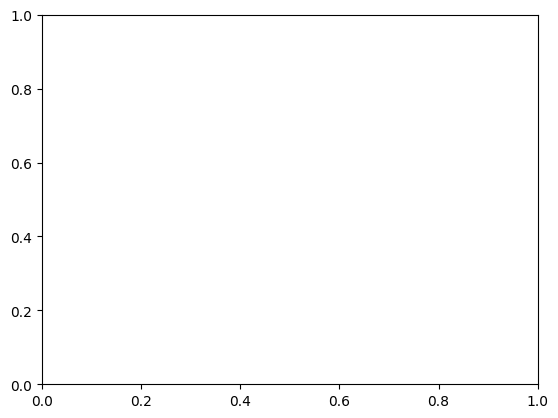

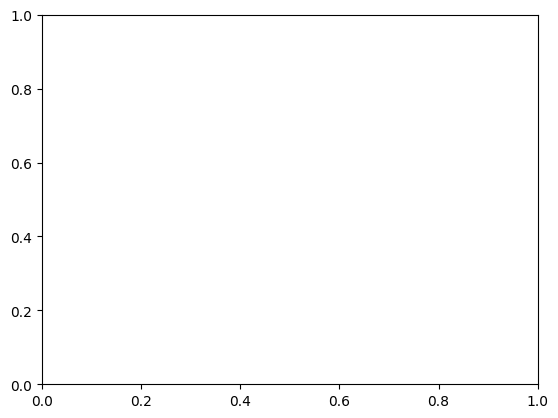

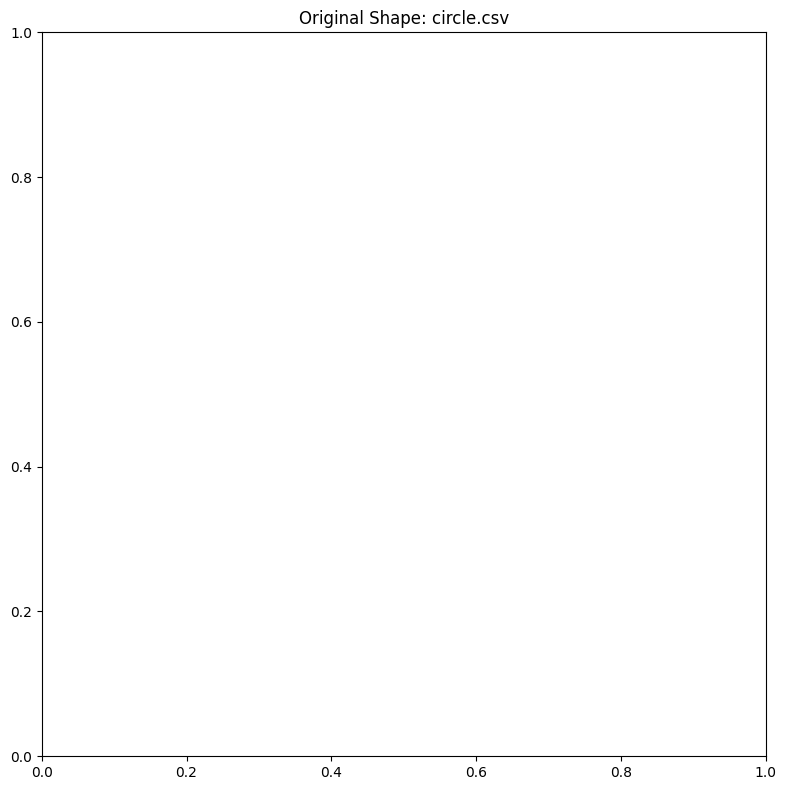

Prediction saved to /content/drive/MyDrive/curve_project/output/predictions/circle_prediction_1.png


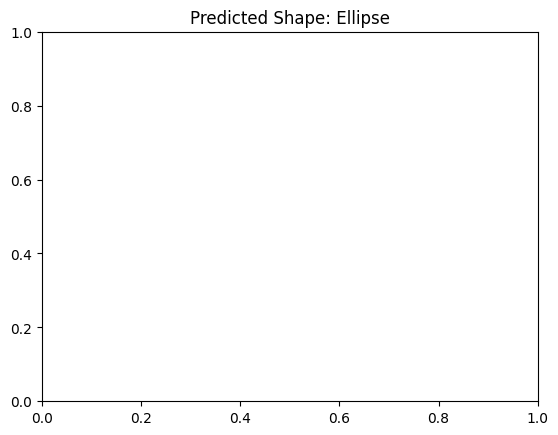

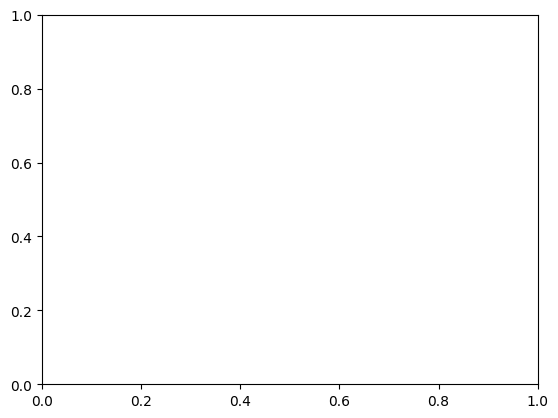

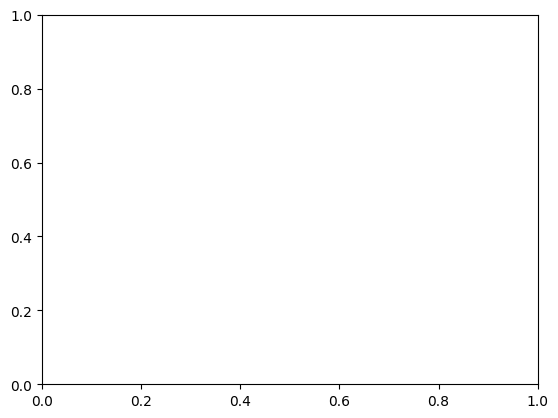

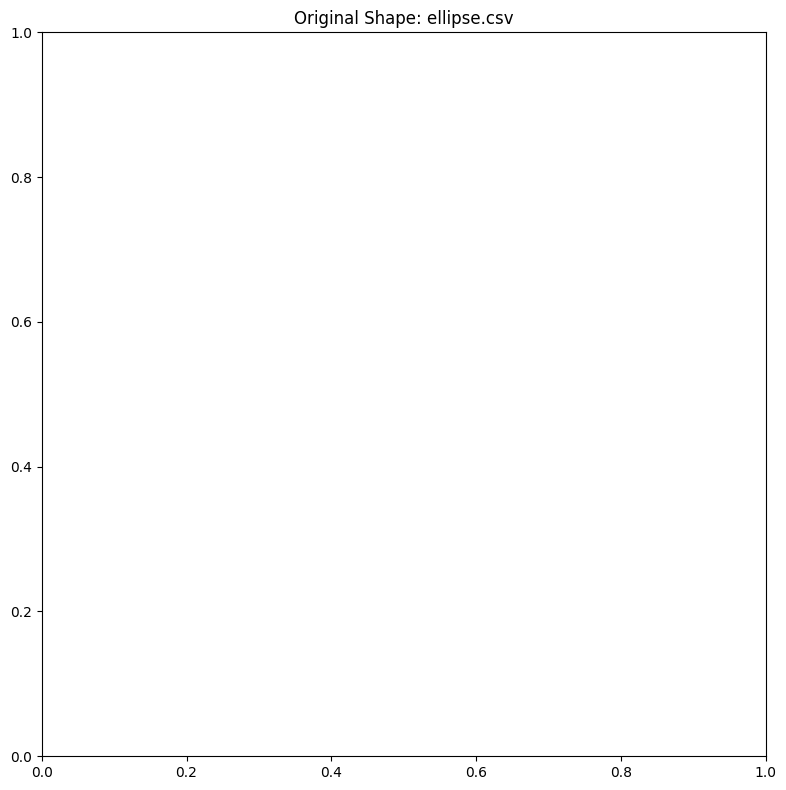

Prediction saved to /content/drive/MyDrive/curve_project/output/predictions/ellipse_prediction_1.png


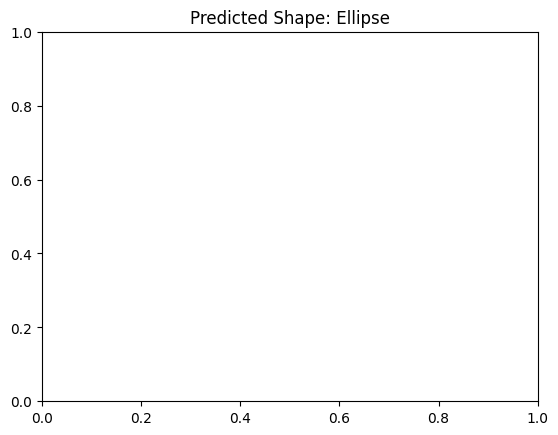

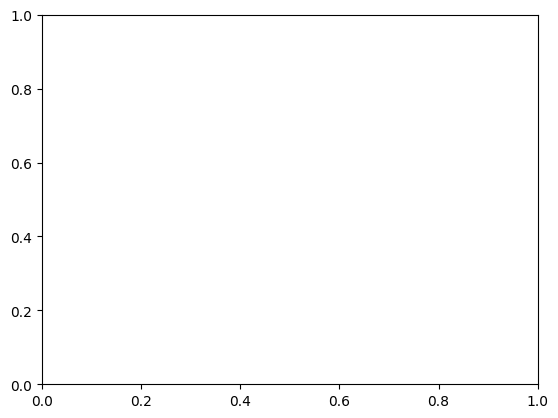

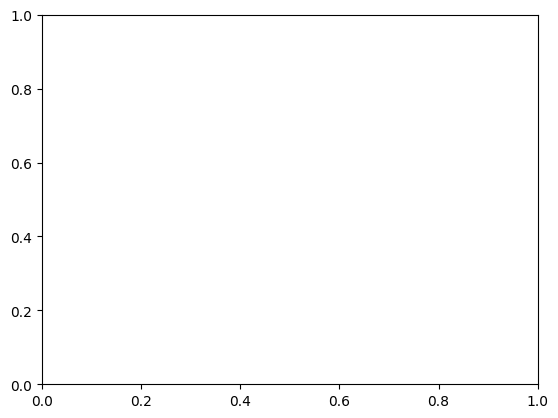

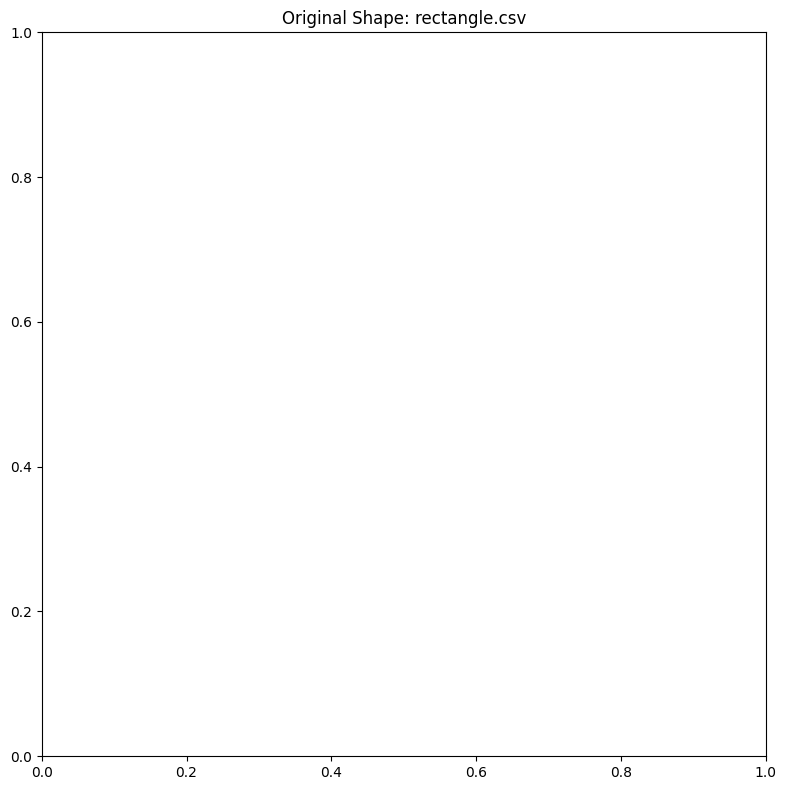

Prediction saved to /content/drive/MyDrive/curve_project/output/predictions/rectangle_prediction_1.png


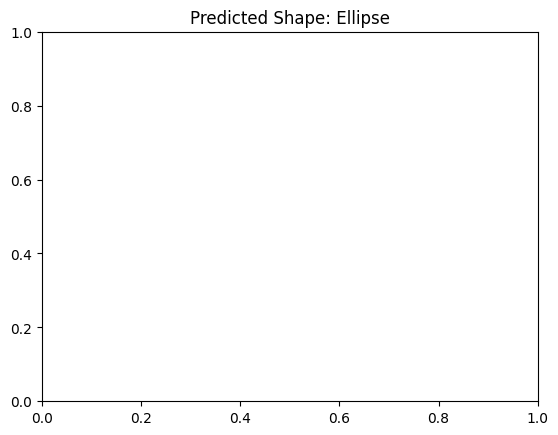

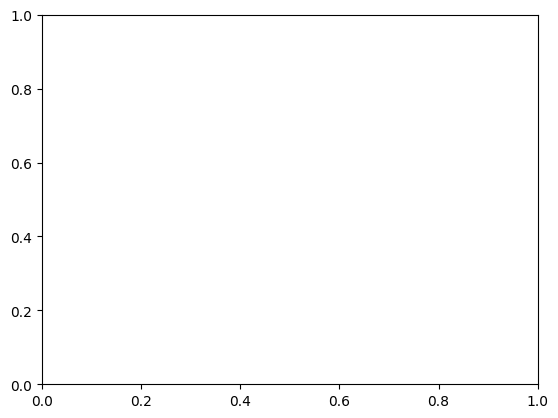

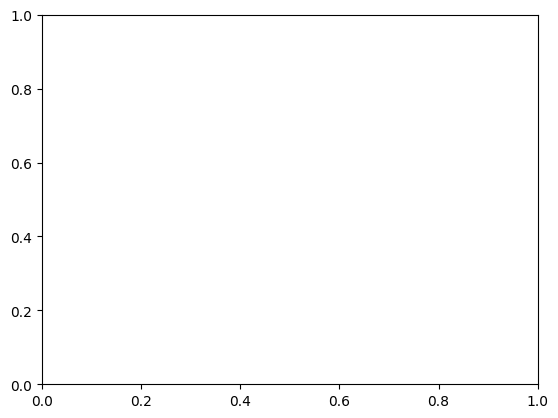

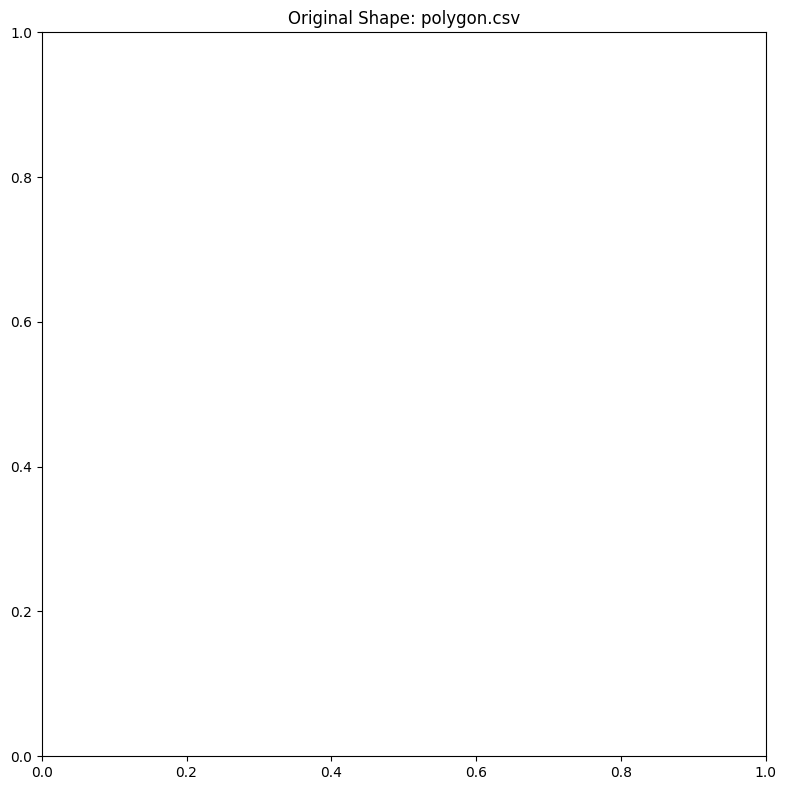

Prediction saved to /content/drive/MyDrive/curve_project/output/predictions/polygon_prediction_1.png


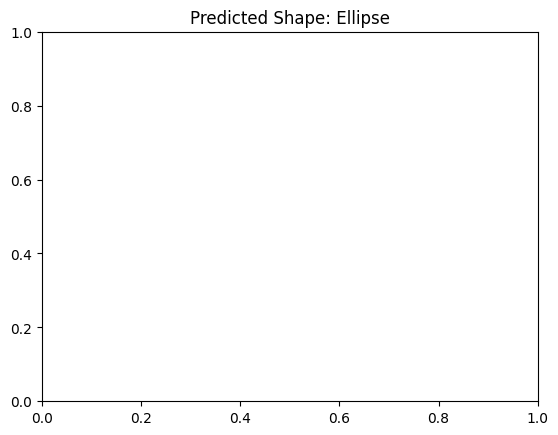

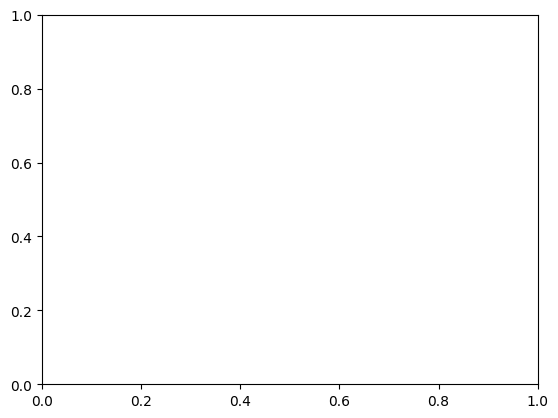

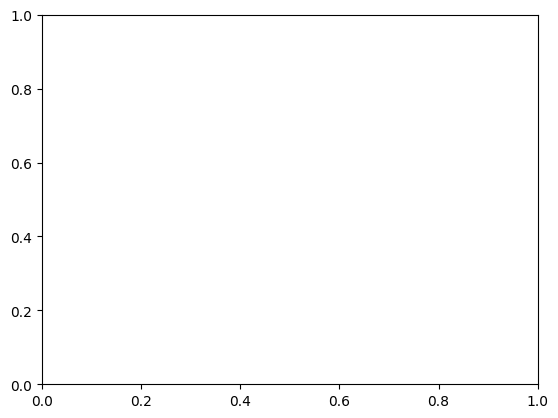

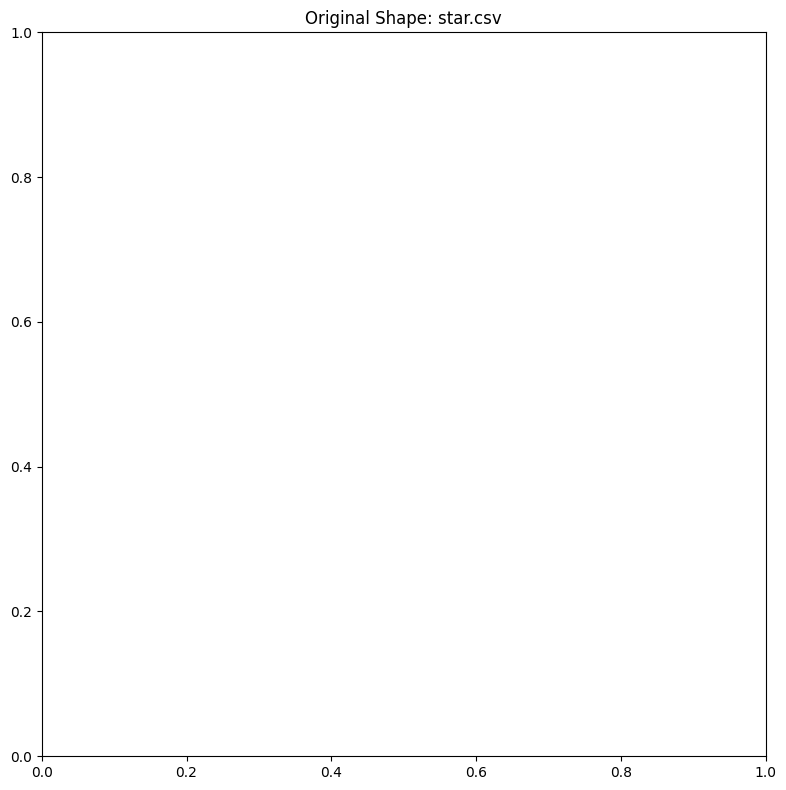

Prediction saved to /content/drive/MyDrive/curve_project/output/predictions/star_prediction_1.png


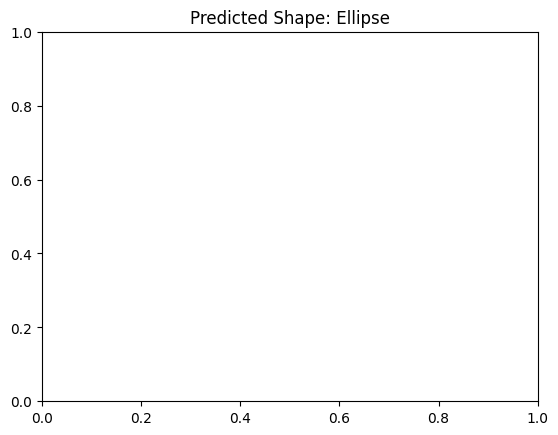

In [24]:
# main.py

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Ensure output directories exist
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Predict the shape using the model
def predict_shape(model, image, device):
    # Transform the image to match the input format of the model
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Get the prediction from the model
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

def main():
    # Load the trained model
    model_path = '/content/drive/MyDrive/curve_project/models/shape_recognition_model.pth'
    model = load_model(model_path)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Ensure output directories exist
    ensure_directory_exists('/content/drive/MyDrive/curve_project/output/predictions/')

    # Define the CSV files containing new polylines for prediction
    csv_files = [
        '/content/drive/MyDrive/curve_project/data/circle.csv',
        '/content/drive/MyDrive/curve_project/data/ellipse.csv',
        '/content/drive/MyDrive/curve_project/data/rectangle.csv',
        '/content/drive/MyDrive/curve_project/data/polygon.csv',
        '/content/drive/MyDrive/curve_project/data/star.csv'
    ]

    # Mapping of label indices to shape names
    label_mapping = {0: 'Circle', 1: 'Ellipse', 2: 'Rectangle', 3: 'Polygon', 4: 'Star'}

    for csv_file in csv_files:
        path_XYs = read_csv(csv_file)

        # Plot each shape, make predictions, and save the results
        for i, shape in enumerate(path_XYs):
            fig, ax = plt.subplots()

            # Validate that shape has at least one valid polyline with two columns (X and Y)
            valid_shape = True
            for XY in shape:
                if XY.shape[1] != 2:
                    print(f"Warning: Found XY with shape {XY.shape} in file {csv_file}. Skipping this shape.")
                    valid_shape = False
                    break

            if not valid_shape:
                continue  # Skip this shape if it's not valid

            plot([shape], title=f"Original Shape: {os.path.basename(csv_file)}")

            # Convert plotted shape to an image
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (3,))
            image = Image.fromarray(image)

            # Predict the shape
            predicted_label = predict_shape(model, image, device)
            predicted_shape_name = label_mapping[predicted_label]
            plt.title(f"Predicted Shape: {predicted_shape_name}")

            # Save the plot with prediction
            output_path = f"/content/drive/MyDrive/curve_project/output/predictions/{os.path.basename(csv_file).replace('.csv', f'_prediction_{i}.png')}"
            plt.savefig(output_path)
            print(f"Prediction saved to {output_path}")

if __name__ == "__main__":
    main()
